In [1]:
%reset -f

In [2]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import os
import itertools
from sklearn import metrics
from sklearn import cross_validation
from scipy import interp
import imblearn.metrics as metrics2

import sys
sys.path.insert(1, "/home/xrafael/Projects/myOsa/src/venv/notebook/puntual-monitoring-improved-2017-final/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score
from TypeFeatFS import DiscreteFS, ContinuousFS
from TypeFeatFilter import DiscreteFilter, ContinuousFilter
from OutlierFiltering import OutlierFiltering
from typeFeat_score import typeFeat_score

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

/home/xrafael/Programs/anaconda2/envs/myosa/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### 1. Load data

In [3]:
folder = "more_than_four" #equal_more_four

In [4]:
dfAll =[]
datasets = [0,1,2]
for ds in datasets:
    pathDir = os.path.join('resources','results',folder,'ds_' + str(ds)) 
    path, dirs, files = os.walk(pathDir).next()
    file_count = len(files)

    for num_exp in range(file_count):
        ddf = pd.read_pickle(os.path.join('resources','results', folder,'ds_' + str(ds),'results_pipe_' 
                                         + str(ds) + '_' + str(num_exp) + '.pkl'))
    ddf["ds"] = ds
    print ddf.shape
    dfAll.append(ddf)

(76, 23)
(76, 23)
(76, 23)


In [5]:
dfs = pd.DataFrame(np.vstack(dfAll), columns=ddf.columns)

dfs.cv_f1_mean = pd.to_numeric(dfs.cv_f1_mean)
dfs.cv_rec_mean = pd.to_numeric(dfs.cv_rec_mean)
dfs.cv_prec_mean = pd.to_numeric(dfs.cv_prec_mean)

dfs.cv_f1_std = pd.to_numeric(dfs.cv_f1_std)
dfs.cv_prec_std = pd.to_numeric(dfs.cv_prec_std)
dfs.cv_rec_std = pd.to_numeric(dfs.cv_rec_std)
dfs.exp = pd.to_numeric(dfs.exp)

dfs["cv_f1"] = dfs["cv_f1_mean"].round(2).astype(str).str.cat(dfs["cv_f1_std"].round(2).astype(str), sep="+/-")
dfs["cv_prec"] = dfs["cv_prec_mean"].round(2).astype(str).str.cat(dfs["cv_prec_std"].round(2).astype(str), sep="+/-")
dfs["cv_rec"] = dfs["cv_rec_mean"].round(2).astype(str).str.cat(dfs["cv_rec_std"].round(2).astype(str), sep="+/-")
dfs["num_nones"] = np.sum(np.hstack(((dfs.sm == "none").reshape(-1,1),(dfs.fs == "none").reshape(-1,1))), axis=1)

/home/xrafael/Programs/anaconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


#### 2. Best pipelines per timepoint

In [25]:
ds = 1

In [26]:
class_names = ["Non-compliant","Compliant"]

#Make a copy
df = dfs[dfs.ds == ds].sort_values("cv_f1_mean", ascending=False).copy()

df.cv_f1_mean = pd.to_numeric(df.cv_f1_mean)
df.cv_rec_mean = pd.to_numeric(df.cv_rec_mean)
df.cv_prec_mean = pd.to_numeric(df.cv_prec_mean)
cls = df.iloc[0].pipeline
cls_name = df.iloc[0].cls

print cls_name
print cls,"\n"
print cls.steps[-1][1],"\n"
print df.columns
display(df.iloc[:1][["ds","fs","sm","metric","cls","params","cv_f1","cv_f1_mean"]])

svmRBF
Pipeline(steps=[('Imputer', TypeFeatImputer(allNameCols=array(['GENERO', 'ACTIVO', 'JUBILADO', 'EDAD', 'FUMA', 'FUMA_PAQ_ANY',
       'FUMA_EX_ANYS', 'ALCOHOL', 'ALCOHOL_GR_DIA', 'CAFES_DIA',
       'DEPRESION', 'ANSIEDAD', 'HTA', 'CARDIOPATIA', 'ENF_RESP',
       'DIABETES', 'OBESIDAD', 'DISLIPEMIA', 'OBSTR...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))]) 

SVC(C=15, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False) 

Index([u'exp', u'out', u'fs', u'sm', u'cls', u'metric', u'params', u'tr_f1',
       u'tr_prec', u'tr_rec', u'cv_f1_mean', u'cv_f1_std', u'cv_prec_mean',
       u'cv_prec_std', u'cv_rec_mean', u'cv_rec_std', u'test_f1', u'test_prec',
       u'test_rec', u'test_auc', u'time', u'pipeline', u'ds', u'cv_f1',
       u'cv_prec', u'cv_rec', u'num_nones'],
      

,ds,fs,sm,metric,cls,params,cv_f1,cv_f1_mean
128,1,none,after,f1_weighted,svmRBF,"[0.001, None, 4, 15]",0.82+/-0.06,0.82


In [27]:
datafilenames = []
datafilenames.append(os.path.join('resources','data_partition_cl0_short_no_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_partition_cl0_short_1m_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_partition_cl0_short_3m_1m_monit_14012016.pkl'))


#Load Train & test data
f = file(datafilenames[ds],"rb")
X_train = np.load(f).astype(float)
y_train = np.load(f).astype(int)
X_test = np.load(f).astype(float)
y_test = np.load(f).astype(int)
cols = np.load(f)
tr_codes = np.load(f)
ts_codes = np.load(f)
feat_types = np.load(f)
feat_types = dict(feat_types.tolist())
f.close()

#Join data
X_all = np.vstack((X_train,X_test))
y_all = np.hstack((y_train, y_test)).reshape(-1,1)
all_codes = np.hstack((tr_codes,ts_codes))
print X_all.shape, y_all.shape, all_codes.shape
print X_train.shape, X_test.shape
print np.sum(y_test == 0), np.sum(y_test == 1)
print cols

#Load cv_outer datasets
cv_outer = cross_validation.StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.30, random_state=42)

(42, 63) (42, 1) (42,)
(29, 63) (13, 63)
6 7
['GENDER' 'ACTIVE' 'RETIRED' 'AGE' 'SMOKER' 'SMOKE_PACK_YEAR'
 'SMOKE_EX_YEAR' 'ALCOHOL' 'ALCOHOL_GR_DAY' 'CAFES_DAY' 'DEPRESSION'
 'ANXIETY' 'HTA' 'CARDIOPATHY' 'RESP_DIS' 'DIABETES' 'OBESITY' 'DISLIPEMIA'
 'OBSTR_NASAL_CHRON' 'SNORES' 'REP_SLEEP' 'CRISIS_ASP' 'NOCTURIA'
 'APNEAS_PRES' 'CEFALEA' 'DAY_SOMN' 'AWAKE_NIGHT' 'CONC_DIS'
 'IRR_APAT_DEPRE' 'INSOMNIA' 'ACT_MOTR_NOCT' 'FEEL_REAL_DRE'
 'DREAM_INT_PIROSIS' 'DEC_SEX_DIS' 'IECAS' 'DIURETICS' 'ANTIAGREG'
 'ANTIACID' 'HIPOLIPEM' 'BDZ' 'SLEEP_TIME' 'IAH' 'TIME_SAT<90%' 'IND_DESAT'
 'SIZE' 'BMI' 'CIRC_NECK' 'TAS_MEAN' 'TAD_MEAN' 'SAT_O2' 'PRESS_CPAP'
 'EPWORTH' 'EUROQOL' 'VISUAL' 'TOTAL_USE_HOURS_1' 'MEAN_USE_HOURS_1'
 'AL_IRR_CUT_MASC_1' 'DRY_MOUTH_1' 'TAS_MEAN_1' 'TAD_MEAN_1' 'EPWORTH_1'
 'EUROQOL_1' 'VISUAL_EUROQOL_1' 'LABEL']


In [28]:
datafilenames = []
datafilenames.append(os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl'))
datafilenames.append(os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016_final.pkl'))
datafilenames.append(os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016_final.pkl'))

dfFeatures = pd.read_pickle(datafilenames[ds])
print dfFeatures.shape

(93, 6)


,Name,Description,Values,Type,Cat,Month
RONCA,SNORES,Snores,"'never':0, 'sometimes':1, 'frequently':2, 'alw...",CAT,SYMPTOMS,M0
TRAST_MEM,MEM_DIS,Memmory disorder,"'never':0, 'sometimes':1, 'frequently':2, 'alw...",CAT,SYMPTOMS,M0
EUROQOL,EUROQOL,Questionnaire result for measuring generic hea...,[0-1],NUM,BASAL,M0
ALCOHOL,ALCOHOL,Alcohol intake,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
ANTICOAG,ANTICOAG,Anticoagulant intake,"'no':0, 'yes':1",CAT,THERAPY,M0


#### 3. CV Performances

In [29]:
cv_f1 = cross_validation.cross_val_score(cls, X_train, y_train, 
                                         cv=cv_outer, scoring='f1_weighted', n_jobs=-1)
cv_prec = cross_validation.cross_val_score(cls, X_train, y_train, 
                                         cv=cv_outer, scoring='precision_weighted', n_jobs=-1)
cv_rec = cross_validation.cross_val_score(cls, X_train, y_train, 
                                         cv=cv_outer, scoring='recall_weighted', n_jobs=-1)
cv_auc = cross_validation.cross_val_score(cls, X_train, y_train, 
                                         cv=cv_outer, scoring='roc_auc', n_jobs=-1)

print "\nCV OUTER f1 score: %0.3f  (+/-%0.03f)" % (np.mean(cv_f1), np.std(cv_f1))
print "CV OUTER prec score: %0.3f  (+/-%0.03f)" % (np.mean(cv_prec), np.std(cv_prec))
print "CV OUTER rec score: %0.3f  (+/-%0.03f)" % (np.mean(cv_rec), np.std(cv_rec))
print "CV OUTER auc score: %0.3f  (+/-%0.03f)" % (np.mean(cv_auc), np.std(cv_auc))


CV OUTER f1 score: 0.839  (+/-0.077)
CV OUTER prec score: 0.872  (+/-0.065)
CV OUTER rec score: 0.844  (+/-0.074)
CV OUTER auc score: 0.845  (+/-0.127)


#### 4. Test performances

In [30]:
y_pred = cls.predict(X_test)
y_scores = cls.predict_proba(X_test)
print y_scores.shape
print y_test.shape

test_f1 = metrics.f1_score(y_test, y_pred, average='weighted', pos_label=None)
test_prec = metrics.recall_score(y_test, y_pred, average='weighted', pos_label=1)
test_rec = metrics.precision_score(y_test, y_pred, average='weighted', pos_label=1)
test_auc_w = metrics.roc_auc_score(y_test, y_pred, average='weighted')
test_auc_mi = metrics.roc_auc_score(y_test, y_pred, average="micro")
test_auc_ma = metrics.roc_auc_score(y_test, y_pred, average="macro")

sens = metrics2.sensitivity_score(y_test, y_pred,average='weighted')
spec = metrics2.specificity_score(y_test, y_pred, average='weighted')

print "\nTest performances:\n"
print "F1-weighted: %0.3f" % (test_f1)
print "Precision-weighted: %0.3f" % (test_prec)
print "Recall-weighted: %0.3f" % (test_rec)
print "AUC-weighted: %0.3f" % (test_auc_w)
print "AUC-micro: %0.3f" % (test_auc_mi)
print "AUC-macro: %0.3f" % (test_auc_ma)
print "Sensitivity:", sens
print "Specificity:", spec


print metrics.classification_report(y_test, y_pred)

(13, 2)
(13,)

Test performances:

F1-weighted: 0.761
Precision-weighted: 0.769
Recall-weighted: 0.846
AUC-weighted: 0.786
AUC-micro: 0.786
AUC-macro: 0.786
Sensitivity: 0.769230769231
Specificity: 0.802197802198
             precision    recall  f1-score   support

          0       0.67      1.00      0.80         6
          1       1.00      0.57      0.73         7

avg / total       0.85      0.77      0.76        13



#### 5. Confusion matrix

In [418]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.grid(False)
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, orientation='vertical',shrink=0.3)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

0
Confusion matrix, without normalization
[[6 0]
 [3 4]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.43  0.57]]


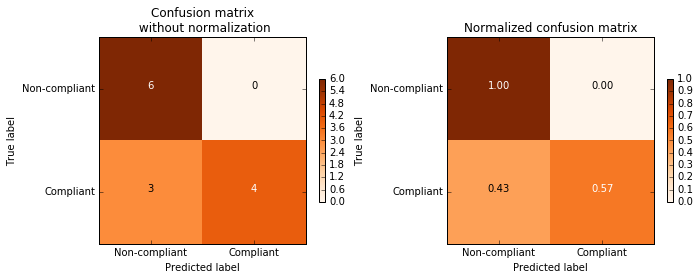

In [419]:
print ds

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix\n without normalization')

# Plot normalized confusion matrix
ax = plt.subplot(1,2,2)
im = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cbar=True)


plt.tight_layout()
plt.show()

#### 4. classification Probabilities

Pipeline(steps=[('Imputer', TypeFeatImputer(allNameCols=array(['GENERO', 'ACTIVO', 'JUBILADO', 'EDAD', 'FUMA', 'FUMA_PAQ_ANY',
       'FUMA_EX_ANYS', 'ALCOHOL', 'ALCOHOL_GR_DIA', 'CAFES_DIA',
       'DEPRESION', 'ANSIEDAD', 'HTA', 'CARDIOPATIA', 'ENF_RESP',
       'DIABETES', 'OBESIDAD', 'DISLIPEMIA', 'OBSTR...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
[ 0.39  0.6   0.68  0.61  0.49  0.38  0.42  0.39  0.46  0.45  0.76  0.42
  0.46]


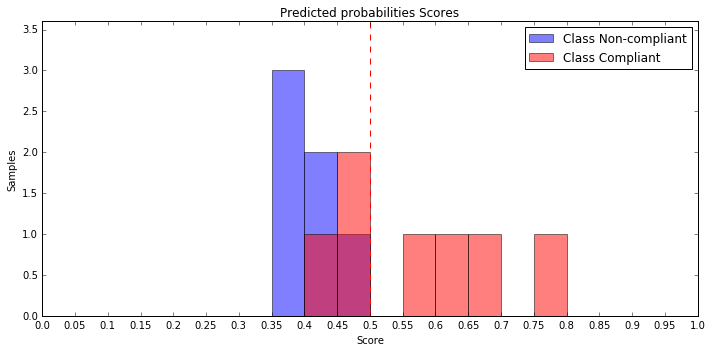

In [420]:
# Plot the two-class decision scores
plot_colors = "br"
plot_step = 0.02

twoclass_output = cls.predict_proba(X_test)[:,1]
plot_range = (twoclass_output.min(), twoclass_output.max())
print cls
print twoclass_output


plt.figure(figsize=(10, 5))
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y_test == i],
             bins=20,
             range=(0,1.0),
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Predicted probabilities Scores')
plt.axvline(0.5,label="Default threshold",c="r",ls="--")
plt.xticks(np.arange(0,1.05,0.05), np.arange(0,1.05,0.05))
plt.xlim(0,1)
plt.tight_layout()

#### 6. Precision-recall curve

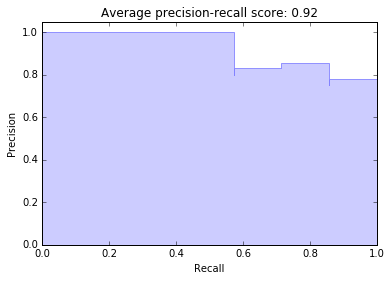

In [185]:
if cls_name == "rf":    
    y_prob = cls.predict_proba(X_test)
    average_precision = metrics.average_precision_score(y_test, y_prob[:,1], average="weighted")
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob[:,1])
else: 
    y_score = cls.decision_function(X_test)
    average_precision = metrics.average_precision_score(y_test, y_score, average="weighted")
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision-recall score: {0:0.2f}'.format(average_precision))
plt.show()

#### 7. Classification boundaries

In [394]:
#pca
from sklearn.decomposition import PCA

print X_test.shape

X_test_trans = X_test.copy()
for s in range(len(cls.steps) - 1):
    if cls.steps[s][0] != "sm_smote":
        X_test_trans = cls.steps[s][1].transform(X_test_trans)  
        print "Test:", X_test_trans.shape

X_train_trans = X_train.copy()
for s in range(len(cls.steps) - 1):
    if cls.steps[s][0] != "sm_smote":
        X_train_trans = cls.steps[s][1].transform(X_train_trans)  
        print "Train:", X_train_trans.shape

pca = PCA(n_components=2)
X_r = pca.fit(X_train_trans).transform(X_test_trans)

print "DATASET: {}M".format(ds)
print('explained variance ratio (first components): %s'
      % str(pca.explained_variance_ratio_))
print "explained variance ratio of 2 pcas:", np.sum(pca.explained_variance_ratio_[:2])

(13, 70)
Test: (13, 70)
Test: (13, 70)
Test: (13, 70)
Test: (13, 11)
Train: (29, 70)
Train: (29, 70)
Train: (29, 70)
Train: (29, 11)
DATASET: 2M
explained variance ratio (first components): [ 0.22  0.17]
explained variance ratio of 2 pcas: 0.394013773249


In [395]:
#Make meshgrid

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_r[:, 0].min() - 2, X_r[:, 0].max() + 2
y_min, y_max = X_r[:, 1].min() - 2, X_r[:, 1].max() + 2
print x_min, x_max
print y_min, y_max

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print xx.shape, np.min(xx), np.max(xx)
print yy.shape, np.min(yy), np.max(yy)

X_extra = np.c_[xx.ravel(), yy.ravel()]
x_min_extra, x_max_extra = X_extra[:, 0].min(), X_extra[:, 0].max()
y_min_extra, y_max_extra = X_extra[:, 1].min(), X_extra[:, 1].max()
print x_min_extra, x_max_extra
print y_min_extra, y_max_extra
print X_extra.shape

X_extra_trans = pca.inverse_transform(X_extra)
print X_extra_trans.shape

-3.38236903614 3.54869408304
-3.34922350662 3.93110822265
(73, 70) -3.38236903614 3.51763096386
(73, 70) -3.34922350662 3.85077649338
-3.38236903614 3.51763096386
-3.34922350662 3.85077649338
(5110, 2)
(5110, 11)


In [396]:
# Obtain labels for each point in mesh. Use last trained model
Z = cls.steps[-1][1].predict(X_extra_trans)
print Z.shape
print np.sum(Z==0), np.sum(Z==1)

y_pred_ts = cls.predict(X_test)
print np.sum(y_pred_ts==0), np.sum(y_pred_ts==1)


y_pred_cs = []
for d in range(len(y_pred_ts)):
    if y_pred_ts[d] == y_test[d]:
        if y_pred_ts[d] == 0:
            y_pred_cs.append("blue")
        else:
            y_pred_cs.append("g")
    else:
        y_pred_cs.append("r")

y_pred_cs = np.array(y_pred_cs)
print y_pred_cs
print "Pred errors:", np.sum(y_pred_cs=="r")

(5110,)
2814 2296
4 9
['blue' 'g' 'g' 'g' 'r' 'blue' 'blue' 'blue' 'g' 'r' 'g' 'g' 'g']
Pred errors: 2


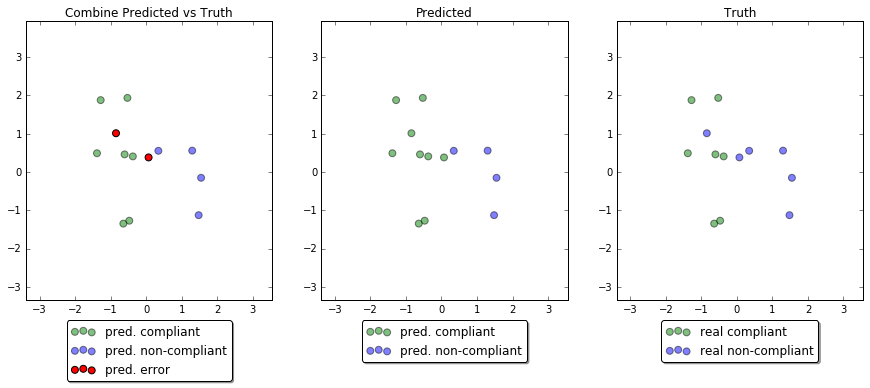

In [397]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)

#Predicted
#ax.scatter(X_r[:, 0], X_r[:, 1], c=y_pred_cs)
ax.scatter(X_r[y_pred_cs=="g", 0], X_r[y_pred_cs=="g", 1], c=["g" for y in y_pred_ts[y_pred_cs=="g"]],label="pred. compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_cs=="blue", 0], X_r[y_pred_cs=="blue", 1], c=["blue" for y in y_pred_ts[y_pred_cs=="blue"]],label="pred. non-compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_cs=="r", 0], X_r[y_pred_cs=="r", 1], c=["r" for y in y_pred_ts[y_pred_cs=="r"]],label="pred. error", s=48)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Combine Predicted vs Truth")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

ax = plt.subplot(1,3,2)
ax.scatter(X_r[y_pred_ts==1, 0], X_r[y_pred_ts==1, 1], c=["g" for y in y_pred_ts[y_pred_ts==1]],label="pred. compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_ts==0, 0], X_r[y_pred_ts==0, 1], c=["blue" for y in y_pred_ts[y_pred_ts==0]],label="pred. non-compliant", alpha=0.5, s=48)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Predicted")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

ax = plt.subplot(1,3,3)
#ax.scatter(X_r[:, 0], X_r[:, 1], c=["g" if y else "blue" for y in y_test], alpha=0.3)
ax.scatter(X_r[y_test==1, 0], X_r[y_test==1, 1], c=["g" for y in y_pred_ts[y_test==1]],label="real compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_test==0, 0], X_r[y_test==0, 1], c=["blue" for y in y_pred_ts[y_test==0]],label="real non-compliant", alpha=0.5, s=48)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Truth")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

plt.show()

### 8. Interpretability

#### 8.1 Select best interpretable classifier

In [633]:
dfDesc = df[np.logical_not(df["cls"].isin(["svmRBF","nn"]))]\
        .sort_values("cv_f1_mean", ascending=False)
display(dfDesc[["fs","sm","metric","cls","params",
          "tr_f1","cv_f1", "cv_prec", "cv_rec",
          "test_f1",'test_prec', 'test_rec']].iloc[:1,:])

cls_int = dfDesc.iloc[0].pipeline
print cls_int.get_params()

,fs,sm,metric,cls,params,tr_f1,cv_f1,cv_prec,cv_rec,test_f1,test_prec,test_rec
182,lasso_fs,after,precision_weighted,rf,"[1, 250, gini, 4, None, None]",1.00,0.87+/-0.15,0.89+/-0.14,0.88+/-0.14,0.84,0.85,0.88


{'lasso_fs__estimator__C': 1, 'lasso_fs': SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        prefit=False, threshold=None), 'Scaler__copy': True, 'lasso_fs__prefit': False, 'lasso_fs__estimator__warm_start': False, 'lasso_fs__estimator__intercept_scaling': 1, 'sm_smote__svm_estimator': None, 'sm_smote__k_neighbors': 4, 'Imputer': TypeFeatImputer(allNameCols=array(['GENERO', 'ACTIVO', ..., 'EUROQOL_3', 'VISUAL EUROQOL_3'], dtype=object),
        dataCatCols=array([1, 1, ..., 0, 0])), 'rf__n_jobs': -1, 'rf__warm_start': False, 'sm_smote__m_neighbors': 10, 'sm_smote__n_jobs': 1, 'lasso_fs__threshold': None, 'sm_smote__ratio': 'auto', 'sm_smote__random_state': 32, 'lasso_fs__estimator': LogisticRegression(C=1, class_weight=None, dual=False, fit_int

#### 8.2 Plot classifier weights

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70


['GENDER' 'ACTIVE' 'RETIRED' 'AGE' 'SMOKER' 'SMOKE_PACK_YEAR'
 'SMOKE_EX_YEAR' 'ALCOHOL' 'ALCOHOL_GR_DAY' 'CAFES_DAY' 'DEPRESSION'
 'ANXIETY' 'HTA' 'CARDIOPATHY' 'RESP_DIS' 'DIABETES' 'OBESITY' 'DISLIPEMIA'
 'OBSTR_NASAL_CHRON' 'SNORES' 'REP_SLEEP' 'CRISIS_ASP' 'NOCTURIA'
 'APNEAS_PRES' 'CEFALEA' 'DAY_SOMN' 'AWAKE_NIGHT' 'CONC_DIS'
 'IRR_APAT_DEPRE' 'INSOMNIA' 'ACT_MOTR_NOCT' 'FEEL_REAL_DRE'
 'DREAM_INT_PIROSIS' 'DEC_SEX_DIS' 'IECAS' 'DIURETICS' 'ANTIAGREG'
 'ANTIACID' 'HIPOLIPEM' 'BDZ' 'SLEEP_TIME' 'IAH' 'TIME_SAT<90%' 'IND_DESAT'
 'SIZE' 'BMI' 'CIRC_NECK' 'TAS_MEAN' 'TAD_MEAN' 'SAT_O2' 'PRESS_CPAP'
 'EPWORTH' 'EUROQOL' 'VISUAL' 'TOTAL_USE_HOURS_1' 'MEAN_USE_HOURS_1'
 'AL_IRR_CUT_MASC_1' 'DRY_MOUTH_1' 'TAS_MEAN_1' 'TAD_MEAN_1' 'EPWORTH_1'
 'EUROQOL_1' 'VISUAL_EUROQOL_1' 'MEAN_USE_HOURS_3' 'DRY_MOUTH_3'
 'TAS_MEAN_3' 'TAD_MEAN_3' 'EPWORTH_3' 'EUROQOL_3' 'VISUAL_EUROQOL_3']
71
70
['SNORES' 'CEFALEA' 'DREAM_INT_PIROSIS' 'ANTIAGREG' 'ANTIACID' 'VISUAL'
 'DRY_MOUTH_1' 'MEAN_USE_HOURS_3' 'E

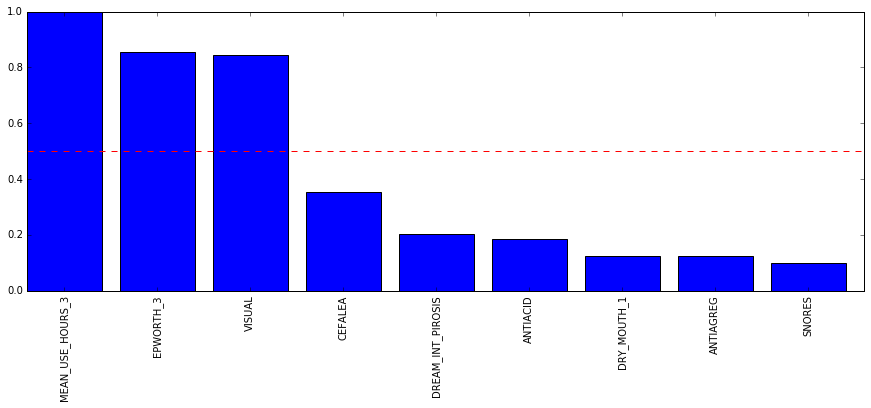

In [646]:
# Plot feature importance
clf = cls_int.steps[-1][1]
var = cls_int.steps[2][1]
var_cols = cols[var.get_support()]

print cols[var.get_support() == 1]
print len(cols)
print len(var_cols)

fs_cols = var_cols
fs_name = cls_int.steps[3][0]
if fs_name in ["lasso_fs","rfe_fs","combined_fs"]:
    fs = cls.steps[3][1]
    fs_cols = var_cols[fs.get_support()]
    print fs_cols, np.sum(fs.get_support()), len(fs_cols)
    
plt.figure(figsize=(15,5))    
if cls_name == "rf":
    feature_importance = clf.feature_importances_
    feature_importance = (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1]
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.bar(np.arange(len(feature_importance)), feature_importance[sorted_idx])
    plt.xticks(np.arange(len(feature_importance))+0.4, fs_cols[sorted_idx], rotation=90)
    plt.xlabel('')
else:
    #feature_importance = clf.coef_[0,:]
    weights = clf.coef_
    weights /= weights.max()
    print weights.shape
    
    sorted_idx = np.argsort(weights[::])[::-1]
    
    plt.bar(np.arange(weights.shape[0])+0.3, weights[sorted_idx])
    plt.xticks(np.arange(weights.shape[0])+0.3,fs_cols[sorted_idx], rotation=90)

plt.axhline(0.5, c="red", ls="--")    
plt.title('')
plt.show()

#### 8.3 Compute feature stability

In [635]:
stab = 100
stab_thr = 0.4
stabArr = dict()
cv_int = cross_validation.StratifiedShuffleSplit(y_train, n_iter=stab, test_size=0.30, random_state=100)
for train_ix, test_ix in cv_int:    
    cls_int.fit(X_train[train_ix],y_train[train_ix])
    
    clf = cls_int.steps[-1][1]
    var = cls_int.steps[2][1]
    var_cols = cols[var.get_support()]

    fs_cols = var_cols
    fs_name = cls_int.steps[3][0]
    if fs_name in ["lasso_fs","rfe_fs","combined_fs"]:
        fs = cls.steps[3][1]
        fs_cols = var_cols[fs.get_support()]
    
    if cls_name == "rf":
        feature_importance = np.abs(clf.feature_importances_)
        weights = (feature_importance / float(feature_importance.max()))
    else:
        weights = np.abs(clf.coef_)
        weights /= float(weights.max())
        weights = weights[0,:]

    for i,w in enumerate(weights):
        if w >= stab_thr:
            col = fs_cols[i]
            if col in stabArr.keys():
                stabArr[col].append(w)
            else:
                stabArr[col] = [w]

dfStab = []        
for j in stabArr.keys():
    k = len(stabArr[j])/100.0
    mean = np.mean(stabArr[j])
    std = np.std(stabArr[j])
    max = np.max(stabArr[j])
    min = np.min(stabArr[j])
    dfStab.append([j, k, mean,std,max,min])

dfStab = pd.DataFrame(dfStab, columns = ["column", "kont", "mean", "std", "max", "min"]) 
dfStab.sort_values(["kont","mean"], ascending = False, inplace=True)

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70


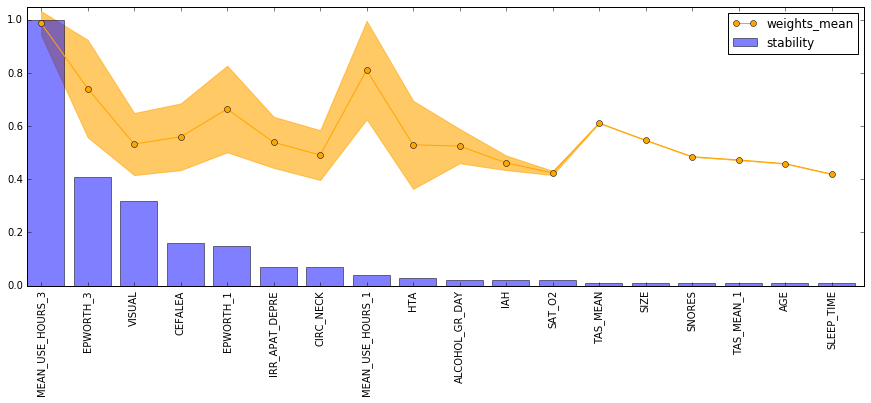

(18, 6)
(2, 6)


,column,kont,mean,std,max,min
6,MEAN_USE_HOURS_3,1.00,0.99,0.05,1.00,0.69
5,EPWORTH_3,0.41,0.74,0.18,1.00,0.42


,column,kont,mean,std,max,min
6,MEAN_USE_HOURS_3,1.00,0.99,0.05,1.00,0.69
5,EPWORTH_3,0.41,0.74,0.18,1.00,0.42
9,VISUAL,0.32,0.53,0.12,0.84,0.40
4,CEFALEA,0.16,0.56,0.13,0.85,0.41
7,EPWORTH_1,0.15,0.66,0.16,1.00,0.47
12,IRR_APAT_DEPRE,0.07,0.54,0.10,0.66,0.41
2,CIRC_NECK,0.07,0.49,0.09,0.70,0.41
14,MEAN_USE_HOURS_1,0.04,0.81,0.19,1.00,0.56
1,HTA,0.03,0.53,0.17,0.76,0.41
17,ALCOHOL_GR_DAY,0.02,0.52,0.06,0.59,0.46


In [637]:
#Plot stability
plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.bar(np.arange(dfStab.shape[0]), dfStab["kont"], alpha=0.5, label="stability")
ax.plot(np.arange(dfStab.shape[0])+0.3, dfStab["mean"],c="orange", marker='o', label="weights_mean")
ax.fill_between(np.arange(dfStab.shape[0])+0.3, 
                dfStab["mean"] - dfStab["std"],
                dfStab["mean"] + dfStab["std"],
                alpha=0.6, color="orange")
    
plt.xticks(np.arange(dfStab.shape[0])+0.3,dfStab["column"],rotation=90)
plt.ylim(0.0,1.05)
plt.legend()
plt.show()

#Stability table
print dfStab.shape
print dfStab[dfStab["kont"]>=0.4].shape
display(dfStab[dfStab["kont"]>=0.4])
display(dfStab)

#### 8..2 Feature  Plots

In [400]:
features = sorted_idx[:5]
names = fs_cols[features]
data = np.hstack((X_train, y_train.reshape(-1,1)))
data = pd.DataFrame(data, columns=cols)

print data.shape
display(data.describe().T)

(29, 71)


,count,mean,std,min,25%,50%,75%,max
GENERO,29.00,0.76,0.44,0.00,1.00,1.00,1.00,1.00
ACTIVO,29.00,0.55,0.51,0.00,0.00,1.00,1.00,1.00
JUBILADO,29.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
EDAD,29.00,57.48,12.77,33.00,48.00,57.00,66.00,81.00
FUMA,29.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
FUMA_PAQ_ANY,29.00,185.79,285.96,0.00,0.00,0.00,365.00,"1,095.00"
FUMA_EX_ANYS,29.00,2.46,5.13,0.00,0.00,0.00,1.00,20.00
ALCOHOL,29.00,0.48,0.51,0.00,0.00,0.00,1.00,1.00
ALCOHOL_GR_DIA,29.00,4.23,8.42,0.00,0.00,0.00,5.00,40.00
CAFES_DIA,29.00,1.38,1.37,0.00,0.00,1.00,2.00,5.00


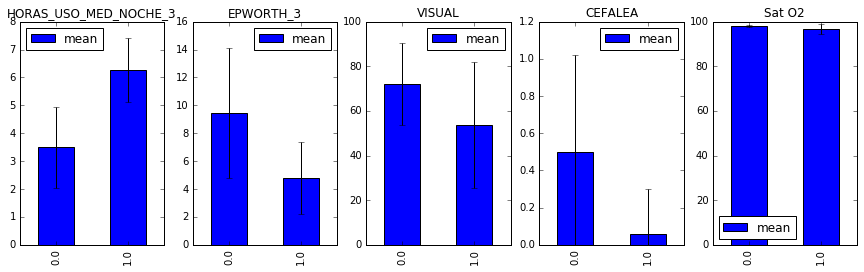

In [401]:
plt.figure(figsize=(15,4))
for i,n in enumerate(names):
    ax = plt.subplot(1,len(names), i+1)
    data.groupby("LABEL")[n].agg(["mean","std"]).plot(kind="bar", ax=ax, yerr="std")
    ax.set_title(n)
    ax.set_xlabel("")
    ax.set_ylim(bottom=0)

plt.show()    

#### 9. ROC curve

##### 9.1 ROC Test set

[0 1 1 1 0 0 0 0 1 0 1 1 1]
[0 1 1 1 1 0 0 0 1 1 1 1 1]

0.952380952381
[ 0.29  0.71  0.71  1.    1.  ]
[ 0.    0.    0.17  0.17  1.  ]


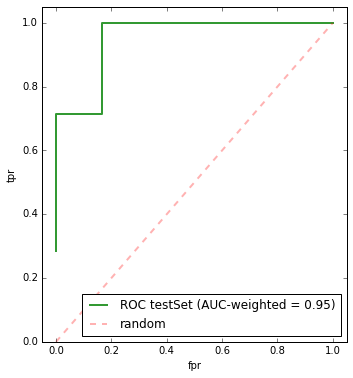

In [410]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

#y_score = cls.decision_function(X_test) #For D0 & D1
y_pred = cls.predict(X_test)
y_prob = cls.predict_proba(X_test)
    
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_prob[:,1], pos_label=1)
#fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_score, pos_label=1)

test_auc_w = metrics.roc_auc_score(y_test, y_prob[:,1], average='weighted')
#test_auc_w = metrics.roc_auc_score(y_test, y_score, average='weighted')

print y_test
print y_pred
print
print test_auc_w
print tpr_test
print fpr_test

plt.figure(figsize=(12,6))

ax = plt.subplot(1,2,1)
ax.plot(fpr_test, tpr_test, color="g",
         label='ROC testSet (AUC-weighted = %0.2f)' % (test_auc_w),lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.3)
ax.legend(loc='lower right')
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0,1.05)
plt.show()

##### 9.2 ROC CV set

('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))
[ 0.    0.2   0.76  0.84  0.94  0.96  0.98  1.  ]
[ 0.    0.    0.03  0.55  0.7   0.93  0.95  1.  ]


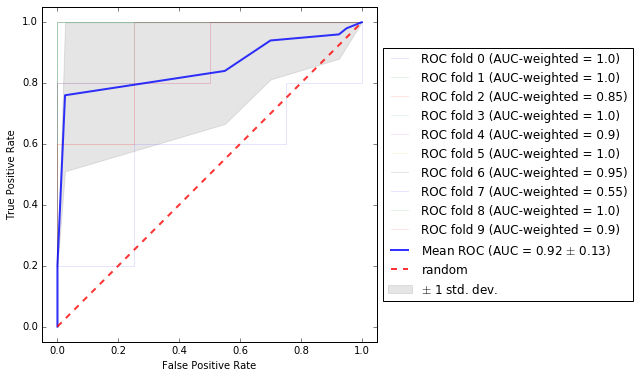

In [412]:
tprs = []
fprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 9)

#Compute cv scores
i = 0
print cls.steps[-1]

plt.figure(figsize=(6,6))
for train_ix, test_ix in cv_outer:
    #y_score = cls.fit(X_train[train_ix],y_train[train_ix]).decision_function(X_train[test_ix]) #For D0 & D1
    y_prob = cls.fit(X_train[train_ix],y_train[train_ix]).predict_proba(X_train[test_ix])
    
    # Compute ROC curve and area under the curve
    #fpr, tpr, _ = metrics.roc_curve(y_train[test_ix], y_score, pos_label=1)
    fpr, tpr, _ = metrics.roc_curve(y_train[test_ix], y_prob[:,1], pos_label=1)

    tprs.append(tpr)
    fprs.append(fpr)
    
    #roc_auc = metrics.roc_auc_score(y_train[test_ix], y_score, average='weighted')
    roc_auc = metrics.roc_auc_score(y_train[test_ix], y_prob[:,1], average='weighted')

    
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.1,label="ROC fold {} (AUC-weighted = {})".format(str(i), str(roc_auc)))
    i += 1

#Homogenyze fpr,tpr arrays (adding 0 at beginning and as many 1 as max difference among arrays)    
max = 0
for t in tprs:
    if max < len(t):
        max = len(t)
max += 1

for i in range(len(tprs)):
    tprs[i] = np.insert(tprs[i],0,0)
    fprs[i] = np.insert(fprs[i],0,0)
            
    if len(tprs[i]) < max:
        diff = max - len(tprs[i])        
        for j in range(diff):            
            tprs[i] = np.insert(tprs[i],-1,1)
            fprs[i] = np.insert(fprs[i],-1,1)
            
#Plot auc mean line and shadow mean area
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)

print mean_tpr
print mean_fpr

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

#Plot guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### 10. Learning curve

In [408]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(8,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("% Training set")
    plt.ylabel("F1-score")
    train_sizes_lc, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring="f1_weighted")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.axhline(0.5,color='r',ls='--', label="random")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


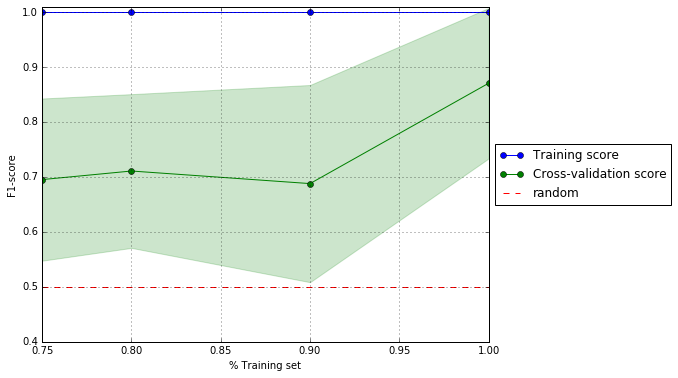

In [409]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
title = ""
plot_learning_curve(cls, title, X_train, y_train, ylim=(0.4, 1.01), 
                    cv=cv_outer,
                    train_sizes=[0.75,0.8,0.9,1.0], 
                    n_jobs=-1)

plt.show()